In [50]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold


# **Data Loading**



In [51]:
# loading dataset
df = pd.read_csv("fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Exploratory Data Analysis**

### **1. Dataset Overview**
We began by examining the Fashion-MNIST dataset, which contains grayscale images of 28×28 pixels representing 10 clothing categories (0–9). The dataset consisted of 60,000 training samples with 1 label column and 784 pixel-value columns.

In [52]:
# basic info
print("\n Dataset shape:")
print(df.shape)

print("\n Dataset info:")
print(df.info())

print("\n Summary statistics:")
print(df.describe())


 Dataset shape:
(60000, 785)

 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None

 Summary statistics:
              label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pi

### **2. Missing Values Check**
A null-value check confirmed that no missing values were present across any of the columns, indicating the dataset was clean and ready for preprocessing.

In [53]:
# check for missing values
missing_cols = df.columns[df.isnull().any()]
if len(missing_cols) == 0:
    print("\n No missing values found.")
else:
    print("\n Columns with missing values:")
    print(df[missing_cols].isnull().sum())


 No missing values found.


### **3. Class Distribution**
The class distribution plot showed that all 10 classes were roughly balanced, meaning the model would not be biased toward any single category.


 Class distribution:
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


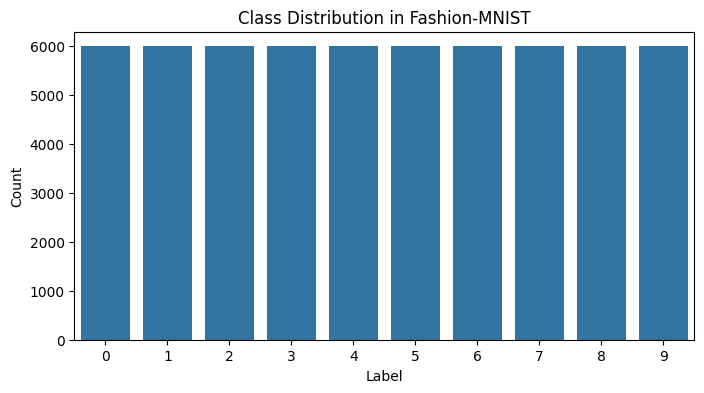

In [54]:
# check class distribution
label_col = 'label'
print("\n Class distribution:")
print(df[label_col].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution in Fashion-MNIST")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### **4. Random Sample Visualization**
Random samples were visualised to provide an initial sense of the dataset’s quality and variation, confirming that the images were clean, centered, and suitable for model training.

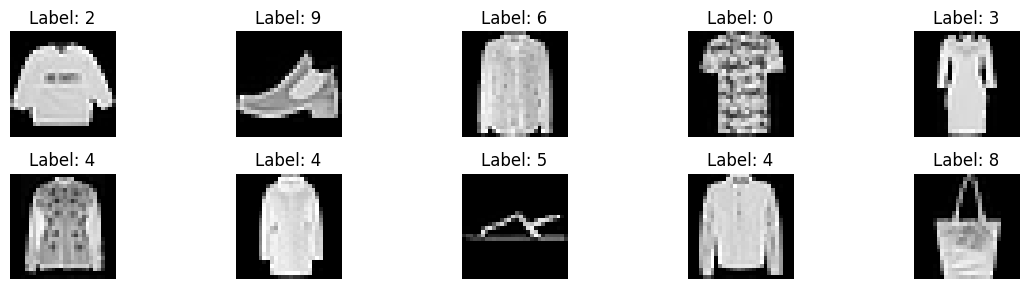

In [55]:
# visualise a few random samples

# each image is 28x28 pixels flattened into 784 columns
image_cols = [col for col in df.columns if col != label_col]

# plot 10 random images
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = df.iloc[i][image_cols].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {df.iloc[i][label_col]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### **5. Per Class Sample Visualisation**

One image from each class was displayed to verify that the dataset included a diverse range of apparel categories.

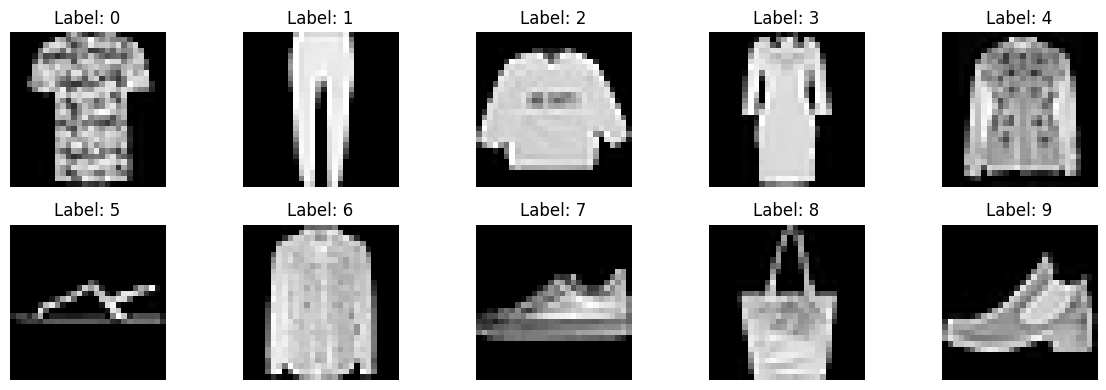

In [56]:
image_cols = [col for col in df.columns if col != 'label']

# get one example index for each unique label
unique_labels = df[label_col].unique()
examples = [df[df[label_col] == lbl].iloc[0] for lbl in sorted(unique_labels)]

plt.figure(figsize=(12, 4))
for i, example in enumerate(examples):
    plt.subplot(2, 5, i + 1)
    img = example[image_cols].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {example[label_col]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

This is random image of each label.



*   **Label 0**: T-shirt/top
*   **Label 1**: Trouser
*   **Label 2**: Pullover
*   **Label 3**:Dress
*   **Label 4**:Coat
*   **Label 5**: Sandal
*   **Label 6**: Shirt
*   **Label 7**: Sneaker
*   **Label 8**:Bag
*   **Label 9**: Ankle boot


We noted that T shirt and shirt look visually similar, hence need to consider data augmentation. Small rotations, shifts, and zooms help model generalize subtle visual differences.


## **6. Pixel Intensity Analysis**
The pixel intensity distribution revealed a strong concentration of values near zero, indicating that most pixels represent dark backgrounds. A smaller range of higher intensities (100–255) corresponds to the lighter clothing areas. This imbalance is expected given the black background and white foreground structure of the images.

The result highlights the importance of normalizing pixel values before model training to ensure numerical stability and improve feature extraction. The clear contrast between background and object boundaries also suggests that the dataset provides strong edge information for visual feature extraction.

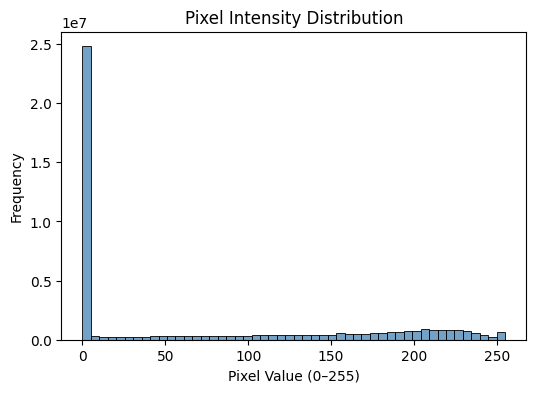

In [57]:
# pixel intensity distribution
plt.figure(figsize=(6,4))
sns.histplot(df[image_cols].values.flatten(), bins=50, color='steelblue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Frequency")
plt.show()

### **6. Mean and Standard Deviation Images**
The mean image revealed a centered, bright silhouette, indicating that most clothing items are well-aligned and occupy similar regions within the frame. In contrast, the standard deviation image showed high variability around the clothing edges, reflecting differences in garment shape and texture.

These findings confirm that the dataset has consistent alignment and background, with variability concentrated in the object regions, which is advantageous for convolutional feature extraction.

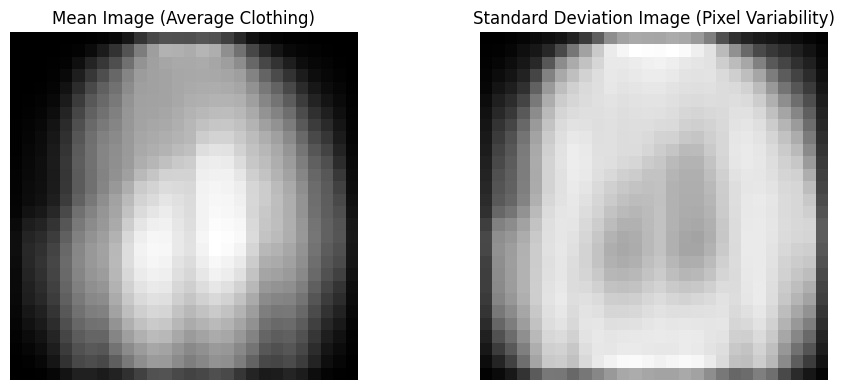

In [58]:
# mean and standard deviation images
# compute across all samples for each pixel
mean_image = df[image_cols].mean().values.reshape(28, 28)
std_image = df[image_cols].std().values.reshape(28, 28)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(mean_image, cmap='gray')
plt.title("Mean Image (Average Clothing)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(std_image, cmap='gray')
plt.title("Standard Deviation Image (Pixel Variability)")
plt.axis('off')

plt.tight_layout()
plt.show()

### **7. Correlation Heatmap**
The correlation heatmap demonstrated strong positive correlations among neighboring pixels, forming structured diagonal patterns that reflect spatial coherence. This indicates that adjacent pixels often vary together, capturing local edges and contours. The presence of such structured correlations implies redundancy in raw pixel features, supporting the use of convolutional or dimensionality-reduction techniques to efficiently learn spatial dependencies.

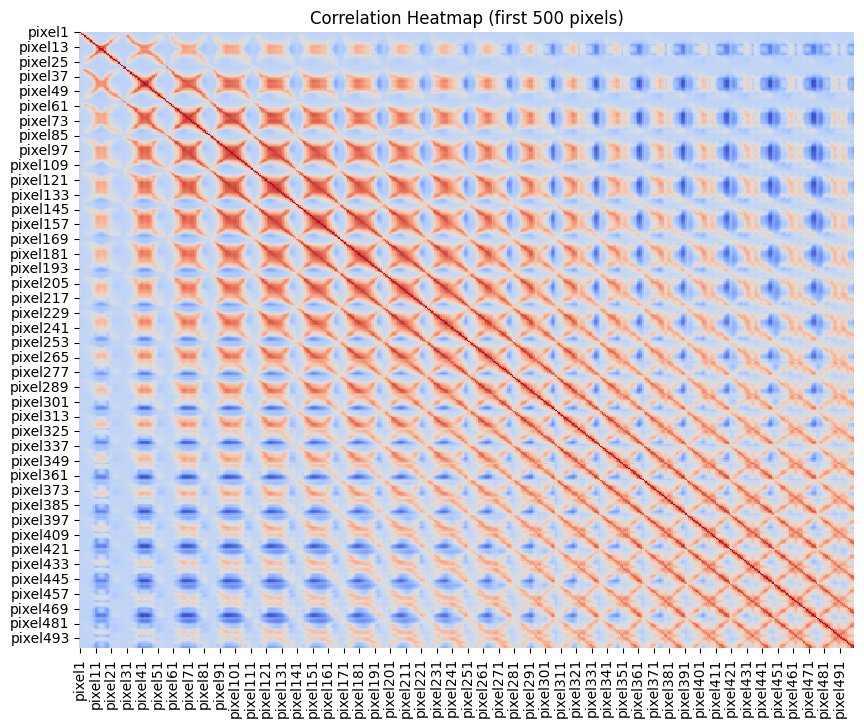

In [59]:
# correlation heat map
# for visualization of relationships (sample only first 500 pixels to reduce size)
plt.figure(figsize=(10,8))
sample_corr = df[image_cols[:500]].corr()
sns.heatmap(sample_corr, cmap='coolwarm', cbar=False)
plt.title("Correlation Heatmap (first 500 pixels)")
plt.show()

### **Key insights and next steps**
The dataset is clean and balanced, with consistent grayscale 28×28 images representing ten clothing categories. Pixel intensity and correlation analyses confirm structured spatial patterns suitable for convolutional neural networks. Subsequent steps will include normalization, train-test splitting, and model training to classify the images effectively.

# **Data Preprocessing (for all models)**




In [60]:
# prep data: separate labels and values
y = df['label'].values
X = df.drop('label', axis=1).values

In [61]:
# Normalize pixel intensities to [0, 1]
X = X / 255.0
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (60000, 784) y shape: (60000,)


In [62]:
# 5 fold CV (shared for all models)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [63]:
# Generate and save fold indices
fold_indices = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    fold_indices.append((train_idx, val_idx))
    print(f"Fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}")


Fold 1: train=48000, val=12000
Fold 2: train=48000, val=12000
Fold 3: train=48000, val=12000
Fold 4: train=48000, val=12000
Fold 5: train=48000, val=12000


In [64]:
# mount Google Drive (force remount if needed)
drive.mount('/content/drive', force_remount=True)

# set wd
import os
save_path = "/content/drive/MyDrive/CS3244"
os.makedirs(save_path, exist_ok=True)

# save normalized data + fold indices
np.save(f"{save_path}/X_normalized.npy", X)
np.save(f"{save_path}/y_labels.npy", y)
np.save(f"{save_path}/fold_indices.npy", np.array(fold_indices, dtype=object), allow_pickle=True)

print("\n Files saved to Google Drive:")
print(f"{save_path}/X_normalized.npy")
print(f"{save_path}/y_labels.npy")
print(f"{save_path}/fold_indices.npy")


 Files saved to Google Drive:
/content/drive/MyDrive/CS3244/X_normalized.npy
/content/drive/MyDrive/CS3244/y_labels.npy
/content/drive/MyDrive/CS3244/fold_indices.npy


In [65]:
# to load the normalised data
X = np.load(f"{save_path}/X_normalized.npy")
y = np.load(f"{save_path}/y_labels.npy")
fold_indices = np.load(f"{save_path}/fold_indices.npy", allow_pickle=True)

print("Loaded successfully!")
print("X shape:", X.shape, "| y shape:", y.shape)
print("Number of folds:", len(fold_indices))
print("Example fold sizes:", [len(fold_indices[0][0]), len(fold_indices[0][1])])

Loaded successfully!
X shape: (60000, 784) | y shape: (60000,)
Number of folds: 5
Example fold sizes: [48000, 12000]
